## Project 3: Web APIs & NLP

### Improv vs StandUpComedy

Which of these performing arts do people want to take up? 

"Three key differences between the two to underline: 1) Stand-ups are alone on stage, whereas improv folks are onstage with 2-3 other teammates. 2) Stand-ups craft repeatable messaging designed to sell our audiences on ideas & things we find funny. Improv teams are creating stories on the spot, which forever disappear the moment they're completed – all to never be recreated again. 3) Improv folks are positive." ~ Jon Selig

https://www.linkedin.com/pulse/necessary-distinction-jon-selig/

Improv vs Stand Up Comedy, 2 forms of artistic expression that are commonly and erroneously used interchangeably.  

### Problem Statement

A performing arts centre is thinking of adding courses to their roster for revenue and is looking to compile feedback on Improv and StandUpComedy. 

1. The performing arts centre would like to be able to separate comments from each subreddit for easy reference.
2. They would like to see the terms that are commonly associated with each performing art in order to better formulate their syllabus.
3. As a secondary concern, they would also like to see which art form may respond better to classes and structured instruction.


### Models

I will be using classification models for this project because the main objective stated above is to categorize posts into the subreddits. Multinomial Naive Bayes and Logistic Regression will be used.

Logistic regression is easier to implement, interpret, and very efficient to train. It is very fast at classifying unknown records. It performs well when the dataset is linearly separable. It can interpret model coefficients as indicators of feature importance.

Naive Bayes doesn't require as much training data. It handles both continuous and discrete data. It is highly scalable with the number of predictors and data points. It is fast and can be used to make real-time predictions.

The models will be scored on the following:

Train and test scores
1. Accuracy
2. Sensitivity
3. Specificity
4. Precision

Since the number of improv and StandUpComedy observations are pretty much even, and our objective here is just to correctly and accurately classify the posts in order to garner more information for the best metric to score these models on would be accuracy.

The 4 different metrics will be discussed later on in the project when evaluating the model.

### Scraping of Data

Subreddits scraped in Part 1 and Part 2 Notebooks and datasets saved in 'datasets' folder as csv files.

### Importing of Libraries and Data Cleaning

In [1]:
# Basic imports
import pandas as pd
import numpy as np


# Time
import time
from datetime import datetime

# Visualisation 
import collections
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing 
import re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup


# Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling - Basics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Modelling - Naive Bayes
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Modelling - Logistic Regression
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

# Modelling - Classification metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_roc_curve, roc_auc_score


In [2]:
# importing the datasets to be used
df_improv = pd.read_csv('datasets/improv.csv')
df_standup = pd.read_csv('datasets/standup.csv')

In [3]:
df_improv.head()

,subreddit,selftext,title
0,improv,[removed],[ REDACTED ] needs your help
1,improv,NaN,hey wanna help some a teen improv troupe
2,improv,NaN,10 things improvisors should do besides improvise
3,improv,I’m starting to feel a little scared. Somethin...,Classes are super expensive
4,improv,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ..."


In [4]:
df_improv.shape

(2000, 3)

In [5]:
df_improv.isnull().sum()

subreddit      0
selftext     476
title          0
dtype: int64

In [6]:
df_improv['selftext'].unique()

array(['[removed]', nan,
       'I’m starting to feel a little scared. Something about all this feels predatory, especially on older adults. I don’t know how to get class expenses curbed so I’m paying out of pocket but I’d like to continue with my class. I don’t really wanna pay anymore but I feel lonely where I am now. The first six week class was a bit, but if I were to continue, I would be paying a-lot. Should I even continue? Or just wait until I go back to school next year?',
       ...,
       "Hey, so me and some friends from my improv classes are planning on booking space to practice/rehearse and book some stage time with the goal being to audition for spots on the more advanced levels of Second City and the local improv theatres in Toronto. \n\nWe're 6 people who have been taking classes and range from me who's been doing it for half a year or for years since high school. \n\nDuring our practice sessions we're planning on learning/doing a new format every week or two and then 

In [7]:
# replace null values with 0 to be removed later because the titles of those rows can still be used
df_improv.fillna('no_text', inplace = True)

In [8]:
df_improv.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

In [9]:
df_improv.dtypes

subreddit    object
selftext     object
title        object
dtype: object

In [10]:
# now check for null values in df_standup
df_standup.isnull().sum()

subreddit       0
selftext     1556
title           0
dtype: int64

In [11]:
df_standup['selftext'].unique()

array(['&amp;#x200B;\n\n*Processing video box4j3han0na1...*', nan,
       'Ok, I lied it has been about 19 months.\n\n but here is a video of mine performing at an Armature comedy competition in December\n\n[https://www.youtube.com/watch?v=spbvdsd-bDU](https://www.youtube.com/watch?v=spbvdsd-bDU)\n\nso give it to me, any thing that I should focus on improving?\n\nPS: The last couple of minutes was a bit rushed as I was getting the lights and got nervous. You can see a better delivery of the last few minutes (at least I felt better doing it) in a shorter set here:\n\n[https://youtu.be/s\\_sv6LmhINg](https://youtu.be/s_sv6LmhINg)',
       '"Our always hilarious surprise this month is originally from the Great White North and now resides in NYC. Multiple Tonight Show with Jimmy Fallon and Just For Laughs appearances along with spots on Late Show with Stephen Colbert and CONAN are just some of the impressive credits this comic has, also including great reviews from the New York Times and b

In [12]:
# replace null values with 0 to be removed later because the titles of those rows can still be used
df_standup.fillna('no_text', inplace = True)

In [13]:
df_standup.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

In [14]:
df_standup.head()

,subreddit,selftext,title
0,StandUpComedy,&amp;#x200B;\n\n*Processing video box4j3han0na...,FAVE PORN CATEGORY
1,StandUpComedy,no_text,Had a comedian on my podcast !
2,StandUpComedy,no_text,Alleyoop - A dramedy short fiction podcast ser...
3,StandUpComedy,no_text,Banned From Tinder
4,StandUpComedy,no_text,"Oh, Rick! - Full Stand-Up Comedy Documentary (..."


In [15]:
# merging the 2 dataframes together
df = pd.concat([df_improv, df_standup]).reset_index(drop=True)

In [16]:
df

,subreddit,selftext,title
0,improv,[removed],[ REDACTED ] needs your help
1,improv,no_text,hey wanna help some a teen improv troupe
2,improv,no_text,10 things improvisors should do besides improvise
3,improv,I’m starting to feel a little scared. Somethin...,Classes are super expensive
4,improv,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ..."
...,...,...,...
3995,StandUpComedy,no_text,THE Secret
3996,StandUpComedy,no_text,https://youtube.com/shorts/HMyFLG6xdh8?feature...
3997,StandUpComedy,no_text,Comedy material
3998,StandUpComedy,no_text,OLDER IS NOT ALWAYS WISER.. And Don’t believe ...


In [17]:
# convert all text into string format
df[['selftext', 'title']] = df[['selftext', 'title']].astype(str)

In [18]:
# combine the text from selftext and title
df['combined_text'] = df['selftext'] + ' ' + df['title']

In [19]:
df

,subreddit,selftext,title,combined_text
0,improv,[removed],[ REDACTED ] needs your help,[removed] [ REDACTED ] needs your help
1,improv,no_text,hey wanna help some a teen improv troupe,no_text hey wanna help some a teen improv troupe
2,improv,no_text,10 things improvisors should do besides improvise,no_text 10 things improvisors should do beside...
3,improv,I’m starting to feel a little scared. Somethin...,Classes are super expensive,I’m starting to feel a little scared. Somethin...
4,improv,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ...",This sub is all about supporting its fellow pl...
...,...,...,...,...
3995,StandUpComedy,no_text,THE Secret,no_text THE Secret
3996,StandUpComedy,no_text,https://youtube.com/shorts/HMyFLG6xdh8?feature...,no_text https://youtube.com/shorts/HMyFLG6xdh8...
3997,StandUpComedy,no_text,Comedy material,no_text Comedy material
3998,StandUpComedy,no_text,OLDER IS NOT ALWAYS WISER.. And Don’t believe ...,no_text OLDER IS NOT ALWAYS WISER.. And Don’t ...


In [20]:
# HELP CHATGPT, REMOVE ALL UNWANTED STUUFF FROM MY DATA
# removing urls
url_pattern = re.compile(r'https?://\S+|www\.\S+')

In [21]:
df['combined_text'] = df['combined_text'].replace(url_pattern, '', regex=True)

In [22]:
# remove HTML
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

df['combined_text'] = df['combined_text'].apply(remove_html_tags)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [23]:
# remove emails
df['combined_text'] = df['combined_text'].str.replace(r'\S+@\S+', '', regex=True)

In [24]:
# remove emoticons
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

df['combined_text'] = df['combined_text'].apply(lambda x: emoji_pattern.sub(r'', x))                           

In [25]:
# remove dashes
df['combined_text'] = df['combined_text'].str.replace('-', ' ')

# remove &amp;#x200B;
df['combined_text'] = df['combined_text'].str.replace('&amp;#x200B;', ' ')

# remove no_text
df['combined_text'] = df['combined_text'].str.replace('no_text', '')

# remove removed and redacted
df['combined_text'] = df['combined_text'].str.replace('removed', '')
df['combined_text'] = df['combined_text'].str.replace('REDACTED', '')

# remove paragraph breaks
df['combined_text'] = df['combined_text'].str.replace('\n', ' ')

In [26]:
# create new column with lower case string
df['lower_text'] = df['combined_text'].str.lower()

In [27]:
df.shape

(4000, 5)

In [28]:
# Drop duplicated records
df.drop_duplicates(inplace=True)

In [29]:
df.shape

(3920, 5)

In [30]:
# remove square brackets from the dataset

df['combined_text'] = df['combined_text'].str.strip('[]')
df['combined_text'] = df['combined_text'].str.strip('[ ]')
df['lower_text'] = df['lower_text'].str.strip('[]')
df['lower_text'] = df['lower_text'].str.strip('[ ]')

In [31]:
# remove punctuation and symbols
df['lower_text'] = df['lower_text'].str.replace(r'[^\w\s]+', '')

C:\Users\khogu\AppData\Local\Temp\ipykernel_2936\2802811022.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lower_text'] = df['lower_text'].str.replace(r'[^\w\s]+', '')


In [32]:
# eyeball the dataframe again just to check if there are other things to drop
df

,subreddit,selftext,title,combined_text,lower_text
0,improv,[removed],[ REDACTED ] needs your help,needs your help,needs your help
1,improv,no_text,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe
2,improv,no_text,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise
3,improv,I’m starting to feel a little scared. Somethin...,Classes are super expensive,I’m starting to feel a little scared. Somethin...,im starting to feel a little scared something ...
4,improv,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ...",This sub is all about supporting its fellow pl...,this sub is all about supporting its fellow pl...
...,...,...,...,...,...
3995,StandUpComedy,no_text,THE Secret,THE Secret,the secret
3996,StandUpComedy,no_text,https://youtube.com/shorts/HMyFLG6xdh8?feature...,,
3997,StandUpComedy,no_text,Comedy material,Comedy material,comedy material
3998,StandUpComedy,no_text,OLDER IS NOT ALWAYS WISER.. And Don’t believe ...,OLDER IS NOT ALWAYS WISER.. And Don’t believe ...,older is not always wiser and dont believe eve...


In [37]:
df.to_csv('datasets/combined_df')

The data has been cleaned and is ready for pre-processing.

#### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|object|combined_df|A specific online community, and the posts associated with it, on the social media website Reddit.|
|selftext|object|combined_df|Selftext: For self-posts, the body of the post from the subreddit.|
|title|object|combined_df|The title of the post on the subreddits that describe the post.|
|combined_text|object|combined_df|Combination of the selftext and title in that order.|
|lower_text|object|combined_df|combined_text in lower case.|

### Preprocessing

1. Tokenize text
2. Remove stopwords
3. Stemming
4. Lemmatizing

In [38]:
# tokenize the combined text
df['lower_text_tokenized'] = df['lower_text'].apply(lambda x: word_tokenize(x))

In [39]:
# converting subreddit into 1 and 0
df['subreddit'] = df['subreddit'].map({'improv': 1, 'StandUpComedy': 0})

In [40]:
df.head()

,subreddit,selftext,title,combined_text,lower_text,lower_text_tokenized
0,1,[removed],[ REDACTED ] needs your help,needs your help,needs your help,"[needs, your, help]"
1,1,no_text,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,"[hey, wan, na, help, some, a, teen, improv, tr..."
2,1,no_text,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,"[10, things, improvisors, should, do, besides,..."
3,1,I’m starting to feel a little scared. Somethin...,Classes are super expensive,I’m starting to feel a little scared. Somethin...,im starting to feel a little scared something ...,"[im, starting, to, feel, a, little, scared, so..."
4,1,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ...",This sub is all about supporting its fellow pl...,this sub is all about supporting its fellow pl...,"[this, sub, is, all, about, supporting, its, f..."


#### Stemming and Lemmatizing

I will now be running the tokenized text through both Stemming and Lemmatizing in order to compare the 2 and decide which to use for the model.

In [41]:
# using porterstemmer to stem the tonekized text

p_stemmer = PorterStemmer()

def stemming(tokenized_text):
    text = [p_stemmer.stem(word) for word in tokenized_text]
    return text

df['lower_text_stemmed'] = df['lower_text_tokenized'].apply(lambda x: stemming(x))

df.head()

,subreddit,selftext,title,combined_text,lower_text,lower_text_tokenized,lower_text_stemmed
0,1,[removed],[ REDACTED ] needs your help,needs your help,needs your help,"[needs, your, help]","[need, your, help]"
1,1,no_text,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,"[hey, wan, na, help, some, a, teen, improv, tr...","[hey, wan, na, help, some, a, teen, improv, tr..."
2,1,no_text,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,"[10, things, improvisors, should, do, besides,...","[10, thing, improvisor, should, do, besid, imp..."
3,1,I’m starting to feel a little scared. Somethin...,Classes are super expensive,I’m starting to feel a little scared. Somethin...,im starting to feel a little scared something ...,"[im, starting, to, feel, a, little, scared, so...","[im, start, to, feel, a, littl, scare, someth,..."
4,1,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ...",This sub is all about supporting its fellow pl...,this sub is all about supporting its fellow pl...,"[this, sub, is, all, about, supporting, its, f...","[thi, sub, is, all, about, support, it, fellow..."


In [42]:
# using WordNetLemmatizer to lematize tokenized text

lemmatizer = WordNetLemmatizer()

def lemmatizing(tokenized_text):
    # return list of all lemmatized words for their corresponding words 
    text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return text

df['lower_text_lemmatized'] = df['lower_text_tokenized'].apply(lambda x: lemmatizing(x))

df.head()

,subreddit,selftext,title,combined_text,lower_text,lower_text_tokenized,lower_text_stemmed,lower_text_lemmatized
0,1,[removed],[ REDACTED ] needs your help,needs your help,needs your help,"[needs, your, help]","[need, your, help]","[need, your, help]"
1,1,no_text,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,"[hey, wan, na, help, some, a, teen, improv, tr...","[hey, wan, na, help, some, a, teen, improv, tr...","[hey, wan, na, help, some, a, teen, improv, tr..."
2,1,no_text,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,"[10, things, improvisors, should, do, besides,...","[10, thing, improvisor, should, do, besid, imp...","[10, thing, improvisors, should, do, besides, ..."
3,1,I’m starting to feel a little scared. Somethin...,Classes are super expensive,I’m starting to feel a little scared. Somethin...,im starting to feel a little scared something ...,"[im, starting, to, feel, a, little, scared, so...","[im, start, to, feel, a, littl, scare, someth,...","[im, starting, to, feel, a, little, scared, so..."
4,1,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ...",This sub is all about supporting its fellow pl...,this sub is all about supporting its fellow pl...,"[this, sub, is, all, about, supporting, its, f...","[thi, sub, is, all, about, support, it, fellow...","[this, sub, is, all, about, supporting, it, fe..."


In [43]:
df[['lower_text_stemmed', 'lower_text_lemmatized']]

,lower_text_stemmed,lower_text_lemmatized
0,"[need, your, help]","[need, your, help]"
1,"[hey, wan, na, help, some, a, teen, improv, tr...","[hey, wan, na, help, some, a, teen, improv, tr..."
2,"[10, thing, improvisor, should, do, besid, imp...","[10, thing, improvisors, should, do, besides, ..."
3,"[im, start, to, feel, a, littl, scare, someth,...","[im, starting, to, feel, a, little, scared, so..."
4,"[thi, sub, is, all, about, support, it, fellow...","[this, sub, is, all, about, supporting, it, fe..."
...,...,...
3995,"[the, secret]","[the, secret]"
3996,[],[]
3997,"[comedi, materi]","[comedy, material]"
3998,"[older, is, not, alway, wiser, and, dont, beli...","[older, is, not, always, wiser, and, dont, bel..."


When we "stem" data, we take words and attempt to return a base form of the word. The result on this particular dataset has been to cause some of the words to become unrecognizable/do not make sense.

When we "lemmatize" data, we take words and attempt to return their lemma, or the base/dictionary form of a word. For this particular set of words, the effect seems to be better than stemming it as it eliminates the forming of nonsensical words.

I will proceed with the next steps using the lemmatized column.

In [44]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [45]:
# add in stopwords to remove
stop_words = set(stopwords.words('english'))
custom_stopwords = {'improv', 'improviser', 'standup', 'stand up', 'comedy',
                    'im', 'like', 'just', 'dont', 'wa', 'time', 'x200b', 'processing', 'video', 'deleted',
                    'would', 'get', 'one', 'ive', 'stand'
                   }
stop_words.update(custom_stopwords)

In [46]:
# removal of stopwords
def remove_stopwords(text):
    filtered_text = [word for word in text if word.lower() not in custom_stopwords]
    return filtered_text

df['clean_text'] = df['lower_text_lemmatized'].apply(lambda x: remove_stopwords(x))

In [47]:
df['clean_text_str'] = df['clean_text'].map(str)

### EDA and Visualization

I will be using the following to create bar charts on unigrams, bigrams and trigrams in order to visualize and obtain meaningfull data for the model.

1. CVEC (Count Vectorization)
2. TF-IDF (Term Frequency-Inverse Document Frequency)

In [48]:
# Creating seperate series for each subreddit for use in functions to plot visualizations
# imp for improv, suc for StandUpComedy (loving how this turned out given it is about comedy)
imp = df.loc[df['subreddit'] == 1, 'clean_text_str']
suc = df.loc[df['subreddit'] == 0, 'clean_text_str']

In [49]:
# creating function for CVEC bar graphs
def cvec_ngram(rangevals):
    
    # Instantiate cvec
    cvec = CountVectorizer(ngram_range = (rangevals, rangevals), stop_words = stop_words)
    
    # Create dataframesf based on cvec
    imp_visual = cvec.fit_transform(imp)
    imp_visual_df = pd.DataFrame(imp_visual.todense(), columns=cvec.get_feature_names_out())
    suc_visual = cvec.fit_transform(suc)
    suc_visual_df = pd.DataFrame(suc_visual.todense(), columns=cvec.get_feature_names_out())
    
    # Plot bar graph
    plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    imp_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 words in r/improv (CVEC)')
    plt.xlabel('Count(CVEC)')
    plt.ylabel('Words')
    
    plt.subplot(1, 2, 2)
    suc_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 words in r/StandUpComedy (CVEC)')
    plt.xlabel('Count(CVEC)')
    plt.ylabel('Words')
    
    plt.tight_layout()

In [50]:
# creating function for CVEC bar graphs
def tvec_ngram(rangevals):
    
    # Instantiate tvec
    tvec = TfidfVectorizer(ngram_range = (rangevals, rangevals), stop_words = stop_words)
    
    # Create dataframesf based on tvec
    imp_visual = tvec.fit_transform(imp)
    imp_visual_df = pd.DataFrame(imp_visual.todense(), columns=tvec.get_feature_names_out())
    suc_visual = tvec.fit_transform(suc)
    suc_visual_df = pd.DataFrame(suc_visual.todense(), columns=tvec.get_feature_names_out())
    
    # Plot bar graph
    plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    imp_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 words in r/improv (TVEC)')
    plt.xlabel('Count(TVEC)')
    plt.ylabel('Words')
    
    plt.subplot(1, 2, 2)
    suc_visual_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');
    plt.title('Top 20 words in r/StandUpComedy (TVEC)')
    plt.xlabel('Count(TVEC)')
    plt.ylabel('Words')
    
    plt.tight_layout()

#### Visualizing Unigrams

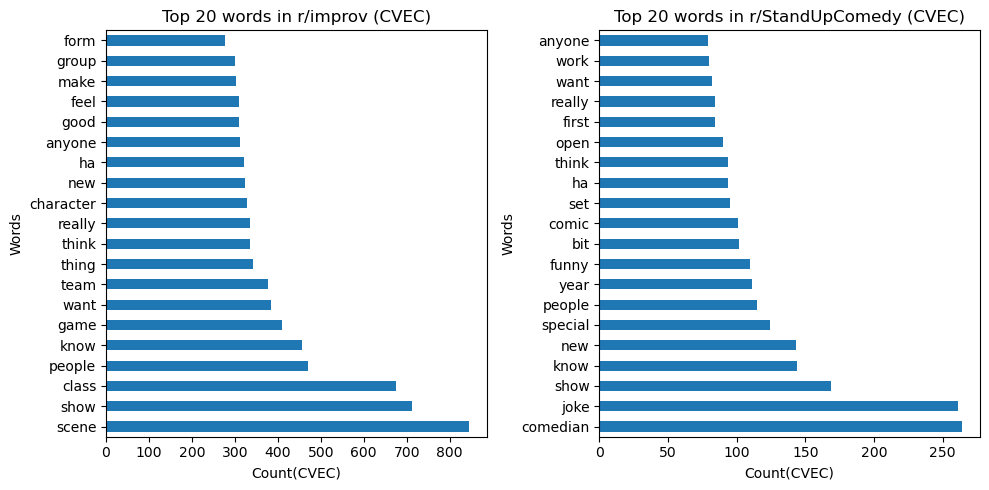

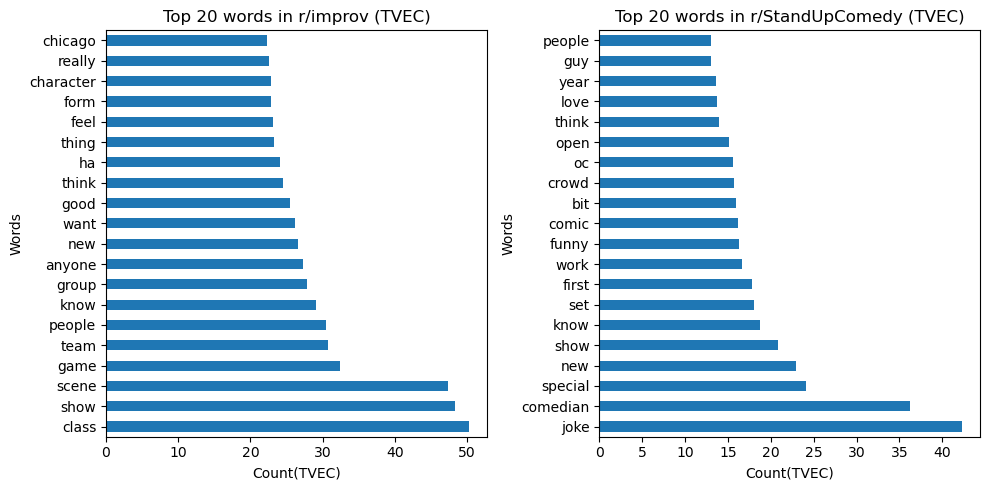

In [51]:
cvec_ngram(1)
tvec_ngram(1)

Observations:

1. Some common words found when checking the unigram include stop words or nonsensical words like "new" and "ha", the latter probably from when people are typing "haha" to simulate laughter.
2. There are also words that are common to both subreddits that might be meaningful, like "show".
3. There are some words that we can see come up uniquely in improv like "class", "scene" and "game", whereas StandUpComedy includes words like "comedian", "joke", "special" and "set".
4. There are predictor words in the unigram that are worth looking at in terms of significance.

#### Visualizing Bigrams

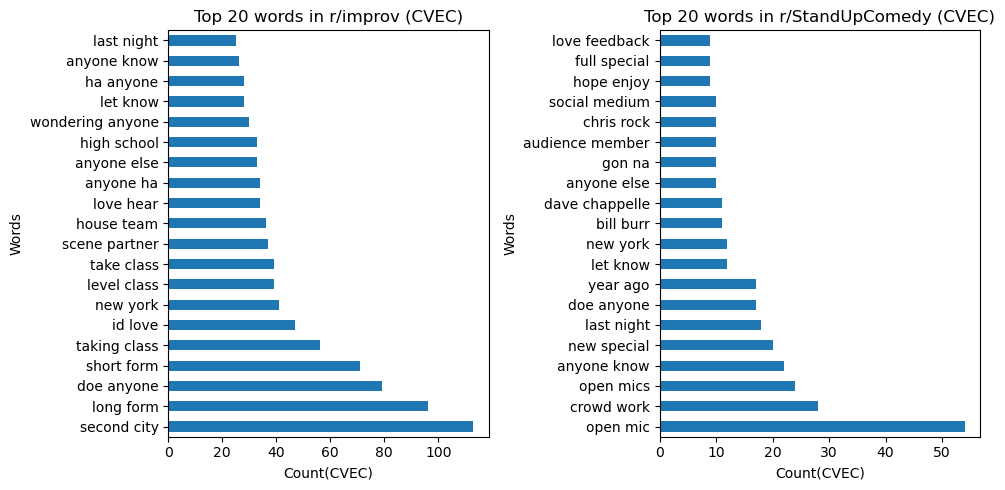

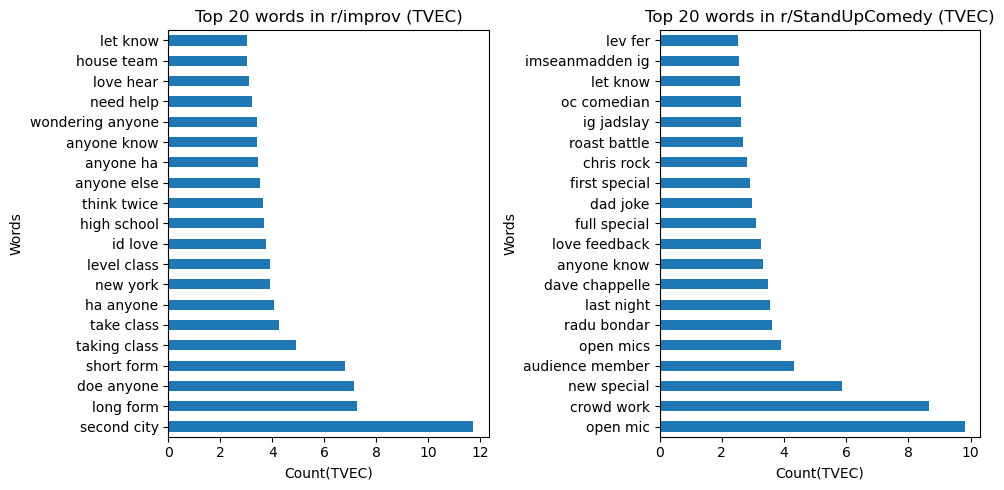

In [52]:
cvec_ngram(2)
tvec_ngram(2)

Observations:

There are fewer occurances for bigrams across the top 20, but it is worth noting that the words found here have less nonsensical words and are more unique to the individual subreddits. Bigrams like long form/short form and take class/taking classes for improv and open mic/open mics, new special and crowd work are common words associated with StandUpComedy.

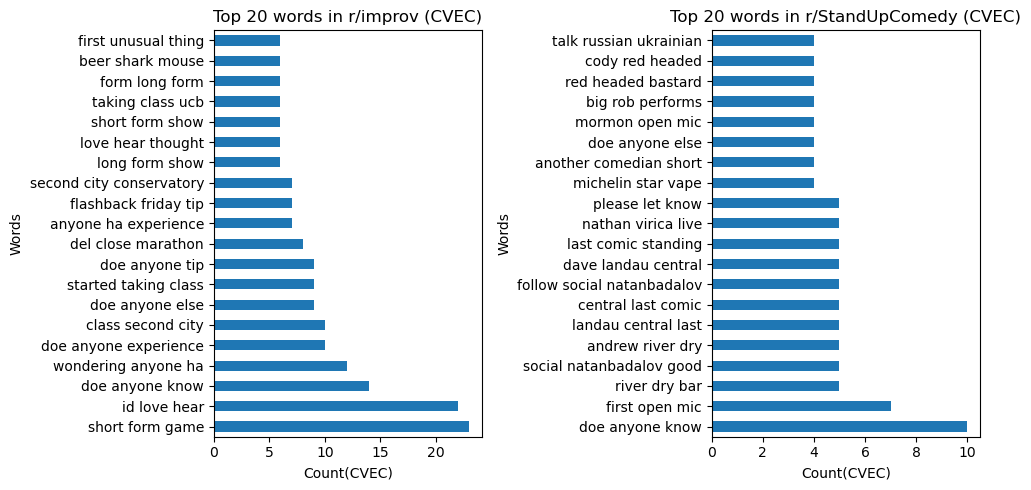

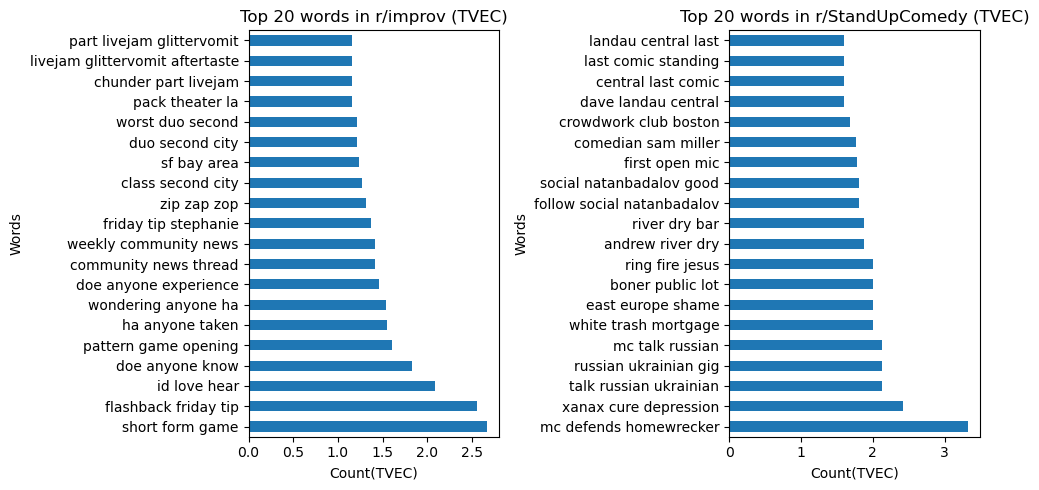

In [53]:
cvec_ngram(3)
tvec_ngram(3)

Observations:

Again, similar to bigram, the trigram returns results that are significantly smaller in values, but offer much more unique results than the unigram. Not much more meaningful information from the bigram, but the results are predictably hilarious for StandUpComedy. Short form game appears again in the improv trigram as with the bigram (short form) which seems to indicate it is a term associated commonly with improv. Same with "open mic" for StandUpComedy.

#### EDA and Visualization round up

The unigram, bigram and trigram all offer unique word/words that may prove useful when predicting. The words also seem pretty uniform across both TVEC and CVEC results in the unigram and bigram. The trigram however shows differing results for StandUpComedy. I will be using both in the models and evaluate them accordingly.

Note: New stop words were added to the list above several times after viewing the visualizations to arrive at this current interation.

### Modeling

#### Baseline

In [54]:
# taking value counts of each subreddit to determine baseline
df['subreddit'].value_counts(normalize=True)

1    0.501276
0    0.498724
Name: subreddit, dtype: float64

In [55]:
df.head()

,subreddit,selftext,title,combined_text,lower_text,lower_text_tokenized,lower_text_stemmed,lower_text_lemmatized,clean_text,clean_text_str
0,1,[removed],[ REDACTED ] needs your help,needs your help,needs your help,"[needs, your, help]","[need, your, help]","[need, your, help]","[need, your, help]","['need', 'your', 'help']"
1,1,no_text,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,hey wanna help some a teen improv troupe,"[hey, wan, na, help, some, a, teen, improv, tr...","[hey, wan, na, help, some, a, teen, improv, tr...","[hey, wan, na, help, some, a, teen, improv, tr...","[hey, wan, na, help, some, a, teen, troupe]","['hey', 'wan', 'na', 'help', 'some', 'a', 'tee..."
2,1,no_text,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,10 things improvisors should do besides improvise,"[10, things, improvisors, should, do, besides,...","[10, thing, improvisor, should, do, besid, imp...","[10, thing, improvisors, should, do, besides, ...","[10, thing, improvisors, should, do, besides, ...","['10', 'thing', 'improvisors', 'should', 'do',..."
3,1,I’m starting to feel a little scared. Somethin...,Classes are super expensive,I’m starting to feel a little scared. Somethin...,im starting to feel a little scared something ...,"[im, starting, to, feel, a, little, scared, so...","[im, start, to, feel, a, littl, scare, someth,...","[im, starting, to, feel, a, little, scared, so...","[starting, to, feel, a, little, scared, someth...","['starting', 'to', 'feel', 'a', 'little', 'sca..."
4,1,This sub is all about supporting its fellow pl...,"Weekly /r/improv promote your upcoming shows, ...",This sub is all about supporting its fellow pl...,this sub is all about supporting its fellow pl...,"[this, sub, is, all, about, supporting, its, f...","[thi, sub, is, all, about, support, it, fellow...","[this, sub, is, all, about, supporting, it, fe...","[this, sub, is, all, about, supporting, it, fe...","['this', 'sub', 'is', 'all', 'about', 'support..."


In [56]:
# Create empty dataframe to store results
model_results = pd.DataFrame(
    columns = [
        'cvec_tvec',
        'classifier',
        'cv_train',
        'accuracy_train',
        'accuracy_test',
        'sensitivity_test',
        'specificity_test',
        'precision_test',
    ]
)

In [57]:
# define X and y
X = df['clean_text_str']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

In [58]:
# create function to run models
def run_grid(X_train, X_test, y_train, y_test):

    # instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        n_jobs = -1, 
        cv = 5,
        verbose = 1
    )

    # fit model
    gs.fit(X_train, y_train)

    # Get predictions
    preds = gs.predict(X_test)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    cm = confusion_matrix(y_test, preds)
    
    # View confusion matrix
    disp = ConfusionMatrixDisplay(cm)
    disp.plot();
      
       
    # results_row
    results_row = [{
        'cvec_tvec' : pipe.steps[0][1],
        'classifier' : pipe.steps[1][1],
        'cv_train' : round(gs.best_score_, 4),
        'accuracy_train': round(gs.score(X_train, y_train), 4),
        'accuracy_test' : round(gs.score(X_test, y_test) ,4),
        'sensitivity_test' : round (tp/(tp+fn), 4),
        'specificity_test' : round (tn/(tn+fp), 4),
        'precision_test' : round (tp/(tp+fp), 4),
    }]
    
    # Print best parameters and scores from GridSearchCV
    print('Best Params:', gs.best_params_)
    print('Best Score:', gs.best_score_)
            
    return results_row

### Multinomial Naive Bayes Model

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'cvec__max_features': 10000, 'cvec__ngram_range': (1, 3), 'nb__alpha': 0.5, 'nb__fit_prior': False}
Best Score: 0.8384353741496599


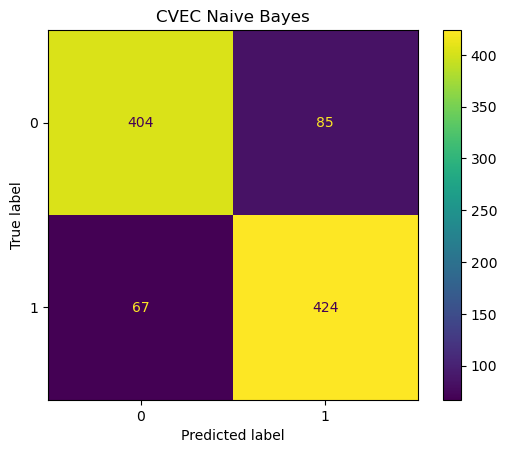

In [59]:
# instantiate cvec and MultinomialNB()
cvec = CountVectorizer()
nb = MultinomialNB()

pipe = Pipeline([
    ('cvec', cvec),
    ('nb', nb)])

params = {
    'cvec__max_features': [10000, 25000, 30000, 35000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]
}

new_results = run_grid(X_train, X_test, y_train, y_test)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Naive Bayes');

In [60]:
model_results

,cvec_tvec,classifier,cv_train,accuracy_train,accuracy_test,sensitivity_test,specificity_test,precision_test
0,CountVectorizer(),MultinomialNB(),0.8384,0.9102,0.8449,0.8635,0.8262,0.833


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'nb__alpha': 0.5, 'nb__fit_prior': False, 'tvec__max_features': 10000, 'tvec__ngram_range': (1, 3)}
Best Score: 0.8282312925170068


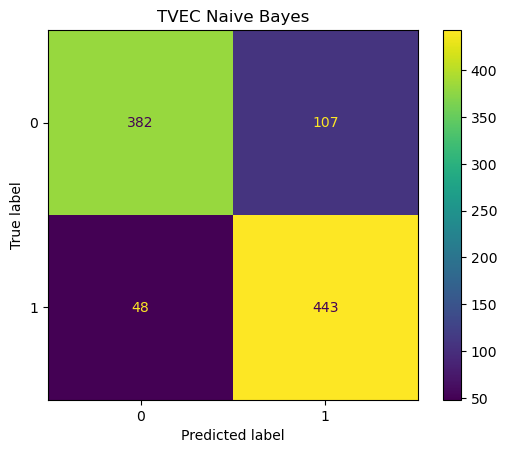

In [61]:
# instantiate tvec and MultinomialNB()
tvec = TfidfVectorizer()
nb = MultinomialNB()

pipe = Pipeline([
    ('tvec', tvec),
    ('nb', nb)])

params = {
    'tvec__max_features': [10000, 25000, 30000, 35000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]
}

new_results = run_grid(X_train, X_test, y_train, y_test)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC Naive Bayes');

In [62]:
model_results

,cvec_tvec,classifier,cv_train,accuracy_train,accuracy_test,sensitivity_test,specificity_test,precision_test
0,CountVectorizer(),MultinomialNB(),0.8384,0.9102,0.8449,0.8635,0.8262,0.8330
0,TfidfVectorizer(),MultinomialNB(),0.8282,0.9388,0.8418,0.9022,0.7812,0.8055


### Logistic Regression

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Params: {'cvec__max_features': 10000, 'cvec__ngram_range': (1, 3), 'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Score: 0.8421768707482993


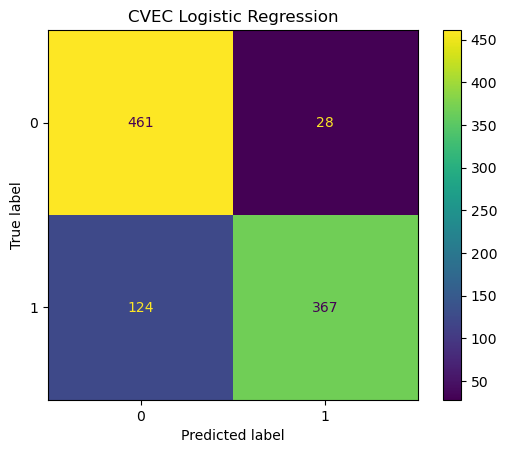

In [63]:
# Instantiate cvec and LogisticRegressionCV()
cvec = CountVectorizer()
logreg = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('logreg', logreg)])

params = {
    'cvec__max_features': [5000, 10000, 15000, 20000],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],     
    'logreg__C': np.linspace(0.01, 0.1, 10), 
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']}


new_results = run_grid(X_train, X_test, y_train, y_test)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Logistic Regression');

In [64]:
model_results

,cvec_tvec,classifier,cv_train,accuracy_train,accuracy_test,sensitivity_test,specificity_test,precision_test
0,CountVectorizer(),MultinomialNB(),0.8384,0.9102,0.8449,0.8635,0.8262,0.8330
0,TfidfVectorizer(),MultinomialNB(),0.8282,0.9388,0.8418,0.9022,0.7812,0.8055
0,CountVectorizer(),LogisticRegression(),0.8422,0.9027,0.8449,0.7475,0.9427,0.9291


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Params: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'tvec__max_features': 15000, 'tvec__ngram_range': (1, 3)}
Best Score: 0.8017006802721088


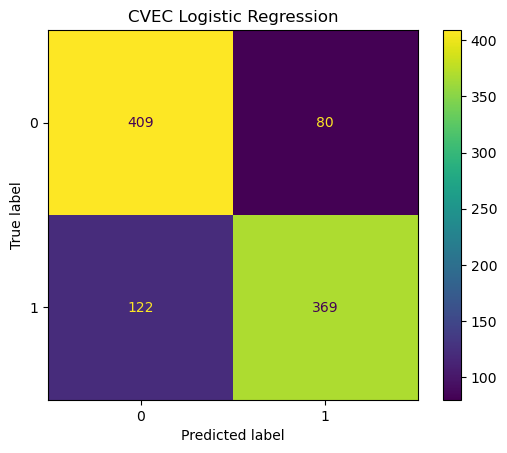

In [65]:
# Instantiate tvec and LogisticRegressionCV()
tvec = TfidfVectorizer()
logreg = LogisticRegression()

pipe = Pipeline([
    ('tvec', tvec),
    ('logreg', logreg)])

params = {
    'tvec__max_features': [5000, 10000, 15000, 20000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],     
    'logreg__C': np.linspace(0.01, 0.1, 10), 
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']
}


new_results = run_grid(X_train, X_test, y_train, y_test)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Logistic Regression');

In [66]:
model_results

,cvec_tvec,classifier,cv_train,accuracy_train,accuracy_test,sensitivity_test,specificity_test,precision_test
0,CountVectorizer(),MultinomialNB(),0.8384,0.9102,0.8449,0.8635,0.8262,0.8330
0,TfidfVectorizer(),MultinomialNB(),0.8282,0.9388,0.8418,0.9022,0.7812,0.8055
0,CountVectorizer(),LogisticRegression(),0.8422,0.9027,0.8449,0.7475,0.9427,0.9291
0,TfidfVectorizer(),LogisticRegression(),0.8017,0.8252,0.7939,0.7515,0.8364,0.8218


#### Scoring metrics, explaining them and elaborating on why we chose to use accuracy

##### Specificity

Specificity is a statistical measure that describes the ability of a binary classifier to identify negative instances correctly. Specifically, it is the proportion of true negative instances that the model correctly identifies as negative.

In other words, specificity is the percentage of negative instances that the model correctly identifies as negative out of all the negative instances in the dataset. It can be calculated using the following formula:

specificity = true negatives / (true negatives + false positives)

where true negatives refer to the number of negative instances that the model correctly identifies as negative, and false positives refer to the number of negative instances that the model incorrectly identifies as positive.

When is specificity a good metric for scoring models?

Specificity is a useful metric when the cost of false positives is high. For example, in medical diagnosis, a false positive can lead to unnecessary treatments and procedures that can be expensive, time-consuming, and potentially harmful to the patient. In such cases, it is essential to have a high specificity to minimize the number of false positives.

In contrast, when the cost of false negatives is high, sensitivity is a more relevant metric. For instance, in fraud detection, a false negative can result in a significant loss of revenue, and it may be more important to minimize false negatives, even at the cost of a higher false positive rate.

In summary, specificity is a critical metric in evaluating the performance of binary classifiers, particularly in applications where the cost of false positives is high.

##### Sensitivity

Sensitivity, also known as recall or true positive rate, is a statistical measure that describes the ability of a binary classifier to identify positive instances correctly. Specifically, it is the proportion of true positive instances that the model correctly identifies as positive.

In other words, sensitivity is the percentage of positive instances that the model correctly identifies as positive out of all the positive instances in the dataset. It can be calculated using the following formula:

sensitivity = true positives / (true positives + false negatives)

where true positives refer to the number of positive instances that the model correctly identifies as positive, and false negatives refer to the number of positive instances that the model incorrectly identifies as negative.

When is sensitivity a good metric for scoring models?

Sensitivity is a useful metric when the cost of false negatives is high. For example, in medical diagnosis, a false negative can lead to a delay in treatment or misdiagnosis, potentially leading to severe consequences for the patient. In such cases, it is essential to have a high sensitivity to minimize the number of false negatives.

Similarly, in fraud detection or spam filtering, a false negative can result in significant financial or reputational damage, making sensitivity a relevant metric to consider.

However, sensitivity may not be the best metric to use in applications where the cost of false positives is high. In such cases, specificity may be a better metric to use, as we discussed in the previous section.

In summary, sensitivity is a crucial metric in evaluating the performance of binary classifiers, particularly in applications where the cost of false negatives is high.

##### Precision

Precision is a statistical measure that describes the ability of a binary classifier to correctly identify positive instances. Specifically, it is the proportion of true positive instances among all the instances that the model identifies as positive.

In other words, precision is the percentage of positive predictions that are correct out of all the positive predictions made by the model. It can be calculated using the following formula:

precision = true positives / (true positives + false positives)

where true positives refer to the number of positive instances that the model correctly identifies as positive, and false positives refer to the number of negative instances that the model incorrectly identifies as positive.

When is precision a good metric for scoring models?

Precision is a useful metric when the cost of false positives is high. For example, in email spam filtering, a false positive can result in legitimate emails being marked as spam, causing frustration and potentially missing important messages. In such cases, it is essential to have a high precision to minimize the number of false positives.

Similarly, in credit risk assessment, a false positive can result in a rejection of a valid application, potentially leading to lost business and dissatisfied customers. Hence, precision is a relevant metric to consider in such applications.

However, precision may not be the best metric to use in applications where the cost of false negatives is high. In such cases, sensitivity may be a better metric to use, as we discussed in the previous question.

In summary, precision is a crucial metric in evaluating the performance of binary classifiers, particularly in applications where the cost of false positives is high.

##### Accuracy

Accuracy is a statistical measure that describes the overall performance of a binary classifier. Specifically, it is the proportion of correct predictions made by the model out of all the predictions it makes.

In other words, accuracy is the percentage of instances that the model correctly identifies as positive or negative out of all the instances in the dataset. It can be calculated using the following formula:

accuracy = (true positives + true negatives) / (true positives + true negatives + false positives + false negatives)

where true positives refer to the number of positive instances that the model correctly identifies as positive, true negatives refer to the number of negative instances that the model correctly identifies as negative, false positives refer to the number of negative instances that the model incorrectly identifies as positive, and false negatives refer to the number of positive instances that the model incorrectly identifies as negative.

When is accuracy a good metric for scoring models?

Accuracy is a useful metric when the cost of false positives and false negatives is roughly equal. In such cases, a balanced approach is needed to achieve high accuracy.

For example, in spam filtering, both false positives and false negatives are costly. A false positive can result in legitimate emails being marked as spam, while a false negative can result in spam messages bypassing the filter. In such cases, it is essential to have a balanced approach that minimizes both false positives and false negatives to achieve high accuracy.

Similarly, in customer segmentation or market research, accuracy can be a relevant metric to consider when the goal is to correctly classify customers or products based on various attributes.

However, accuracy may not be the best metric to use in applications where the cost of false positives or false negatives is significantly different. In such cases, specificity, sensitivity, or precision may be better metrics to use, as we discussed in the previous questions.

In summary, accuracy is a crucial metric in evaluating the performance of binary classifiers, particularly in applications where the cost of false positives and false negatives is roughly equal.

##### Best metric to use

Since the number of improv and StandUpComedy observations are pretty much even, and our objective here is just to correctly and accurately classify the posts in order to garner more information for the best metric to score these models on would be accuracy.

Based on accuracy, the Multinomial Naive Bayes models with both cvec and tvec are over fitted. The Logistic Regression model seems to return better results that will generalize better to unseen data.

The Logistic Regression model with both vectorizers are generally better fit, but the tvec model fits better, with lower accuracy scores. The model with cvec is a little more over fit than the model tvec, but has better accuracy scores. I will proceed with the interpretation of the coefficients with the 2 Logistic Regression models.

### Interpreting Coefficients

Best models and best params:

1. CVEC LogisticRegression()
    Best Params: {'cvec__max_features': 10000, 'cvec__ngram_range': (1, 3), 'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
    
    
2. TVEC LogisticRegression()
    Best Params: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'tvec__max_features': 15000, 'tvec__ngram_range': (1, 3)}

In [121]:
# instantiate cvec and LogisticRegression() and fit model
cvec = CountVectorizer()
logreg = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('logreg', logreg)])

params = {
    'cvec__max_features': [10000],
    'cvec__ngram_range': [(1,3)],     
    'logreg__C': [0.1], 
    'logreg__penalty': ['l2'],
    'logreg__solver': ['liblinear']}

pipe.fit(X_train, y_train)


Pipeline(steps=[('cvec', CountVectorizer()), ('logreg', LogisticRegression())])

In [122]:
# call ou the coefficients of the features
coef = logreg.coef_[0]

In [123]:
# getting the feature names
feature_names = pipe[:-1].get_feature_names_out()

In [124]:
# converting it all into a dataframe
cvec_logreg_coef = pd.DataFrame(coef,feature_names).sort_values(by=0, ascending=False)

In [135]:
cvec_logreg_coef.rename(columns={0: 'logreg_coef'}, inplace=True)

In [136]:
# top 10 predictors for improv
cvec_logreg_coef.head(10)

,logreg_coef
class,3.804624
scene,2.817732
game,2.816446
team,2.568583
ucb,2.520598
group,2.332005
an,2.268176
what,2.235881
and,2.140549
theater,2.134737


In [126]:
# top 10 predictors for StandUpComedy
cvec_logreg_coef.tail(10)

,0
parent,-1.151145
ig,-1.183887
material,-1.279428
oc,-1.282465
crowd,-1.398607
mic,-1.550368
comic,-1.807651
special,-1.943641
comedian,-2.157193
joke,-2.416508


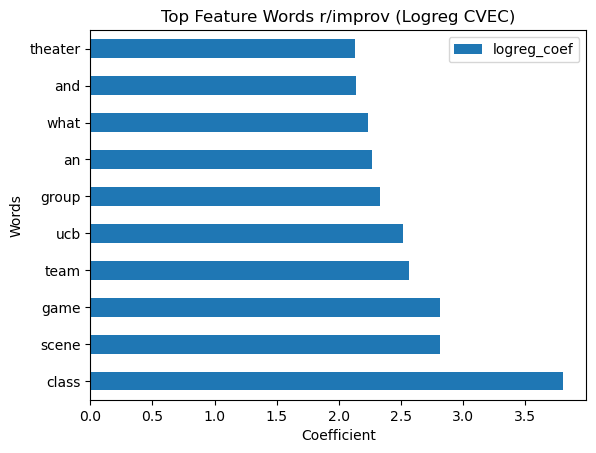

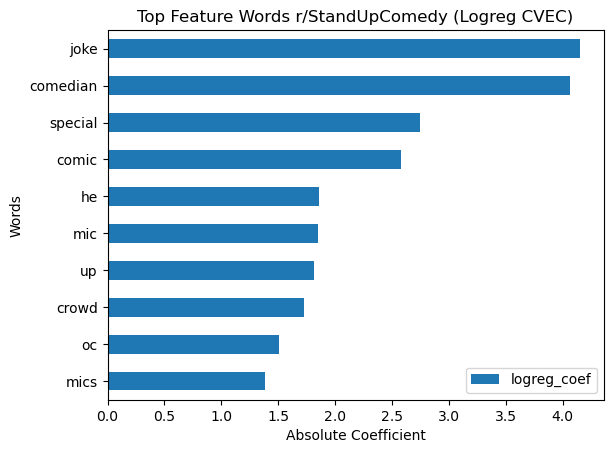

In [154]:
# plot bar chart for the coefficients
cvec_logreg_coef.head(10).plot(kind='barh')
plt.title('Top Feature Words r/improv (Logreg CVEC)')
plt.xlabel('Coefficient')
plt.ylabel('Words');
    
abs(cvec_logreg_coef.tail(10)).plot(kind='barh')
plt.title('Top Feature Words r/StandUpComedy (Logreg CVEC)')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Words');


#### Interpreting the coefficients for Logistic Regression with CountVectorizer

The log coefficient shown above next to the features show how strongly they predict for the 2 subbreddits. The higher the positive value, the better the word predicts for improv, whilst the smaller the negative value, the better it predicts for StandUpComedy.

As can be seen from the top 10 feature predictors for improv, 9 out of 10 are typical words associated with improv literature, namely, "class", "game", "theatre", "team", "troupe", "yes", "audition", "improvisers" and "improvise".

The top 10 feature predictors of StandUpComedy has 7 out of 10 words that are commonly associated with the genre, namely "joke", "comedian", "special", "comic", "mic", "crowd" and "material".

Most of the words are relavent and significant predictors of the 2 topics, improv and StandUpComedy.

In [127]:
# Instantiate tvec and LogisticRegressionCV()
tvec = TfidfVectorizer()
logreg = LogisticRegression()

pipe = Pipeline([
    ('tvec', tvec),
    ('logreg', logreg)])

params = {
    'tvec__max_features': [15000],
    'tvec__ngram_range': [(1,3)],     
    'logreg__C': [0.1], 
    'logreg__penalty': ['l2'],
    'logreg__solver': ['liblinear']}

pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('logreg', LogisticRegression())])

In [128]:
# call ou the coefficients of the features
coef = logreg.coef_[0]

In [129]:
# getting the feature names
feature_names = pipe[:-1].get_feature_names_out()

In [138]:
# converting it all into a dataframe
tvec_logreg_coef = pd.DataFrame(coef,feature_names).sort_values(by=0, ascending=False)

In [139]:
tvec_logreg_coef.rename(columns={0: 'logreg_coef'}, inplace=True)

In [140]:
# top 10 predictors for improv
tvec_logreg_coef.head(10)

,logreg_coef
class,3.804624
scene,2.817732
game,2.816446
team,2.568583
ucb,2.520598
group,2.332005
an,2.268176
what,2.235881
and,2.140549
theater,2.134737


In [141]:
# top 10 predictors for StandUpComedy
cvec_logreg_coef.tail(10)

,logreg_coef
mics,-1.380942
oc,-1.505333
crowd,-1.728946
up,-1.817626
mic,-1.852299
he,-1.857654
comic,-2.581426
special,-2.748098
comedian,-4.062005
joke,-4.149917


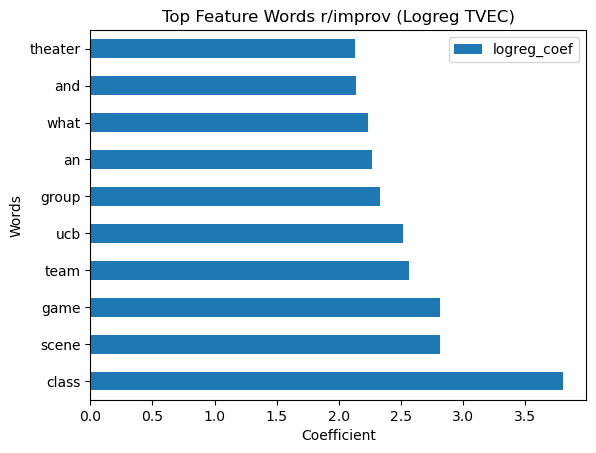

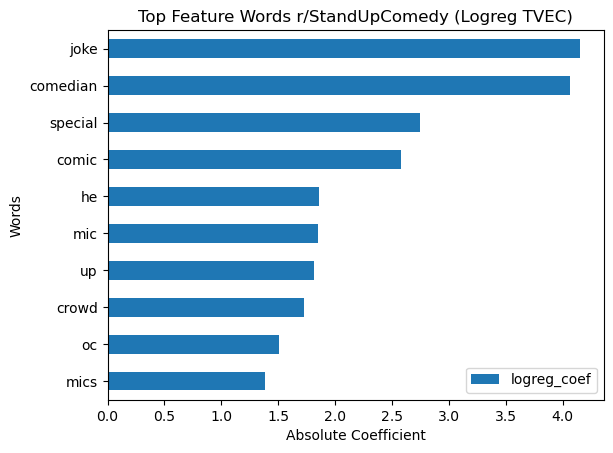

In [155]:
# plot bar chart for the coefficients
tvec_logreg_coef.head(10).plot(kind='barh')
plt.title('Top Feature Words r/improv (Logreg TVEC)')
plt.xlabel('Coefficient')
plt.ylabel('Words');
    
abs(tvec_logreg_coef.tail(10)).plot(kind='barh')
plt.title('Top Feature Words r/StandUpComedy (Logreg TVEC)')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Words');


#### Interpreting the coefficients for Logistic Regression with TfidfVectorizer

The log coefficient shown above next to the features show how strongly they predict for the 2 subbreddits. The higher the positive value, the better the word predicts for improv, whilst the smaller the negative value, the better it predicts for StandUpComedy.

Compared to using the CountVectorizer, usint TFIDfVectorizer has top features predicting improv and standup that are generally similar, but there are more words that are similar to stopwords that may not actually be significant to the topics.

### Conclusion

In [156]:
# displaying model results here for easy reference
model_results

,cvec_tvec,classifier,cv_train,accuracy_train,accuracy_test,sensitivity_test,specificity_test,precision_test
0,CountVectorizer(),MultinomialNB(),0.8384,0.9102,0.8449,0.8635,0.8262,0.8330
0,TfidfVectorizer(),MultinomialNB(),0.8282,0.9388,0.8418,0.9022,0.7812,0.8055
0,CountVectorizer(),LogisticRegression(),0.8422,0.9027,0.8449,0.7475,0.9427,0.9291
0,TfidfVectorizer(),LogisticRegression(),0.8017,0.8252,0.7939,0.7515,0.8364,0.8218


##### Problem statement and data gathering/cleaning:

We set out to gather information that might be useful to your school in forming new classes in improv and StandUpComedy. In order to achieve this, we scraped the 4000 most recent posts from 2 subreddits, 2000 posts from each subreddit to use as a data so the information in that text should reflect current sentiment towards both topics.

Removal of stopwords and other key words that may have caused model over fitting was done over 3 rounds of testing with the models to get to the current iteration. It is worth noting that sometimes this trial and error process is necessary to get the results we want, and if future versions of this model are created, perhaps time, or resources can be allocated to this.

##### EDA and Visualization:

Through our EDA, and the visualizing of unigrams, bigrams and trigrams, we could see some of the common terms and phrases that were present in the different subreddits. Whilst the results were at times hilarious, we could also see patterns unique to each subreddit that were quite telling in differentiating two commonly mistakenly interchangible disciplines.

improv: is mainly a group activity and is commonly associated with scenes, long and short forms, and classes, and can be associated with not just comedy, but also any other form of artistic expression. It is also generally very positively portrayed as a team and group effort.

StandUpComedy: is mainly a solo performance which involves using humour and comedy as it's main entertainment medium. Some of the words associated with it indicate that it is a more popular form of performance in mainstream media, with words like mic, special(as in Netflix special or some other network special or comedy special) would indicate.

Although not in the top predictors for either subreddit, improv has a generally more positive tone to their posts and the art form is generally described as being supportive of the team members and reacting by always saying yes, and continuing to develop the scene. StandUpComedy on the other hand has some negative sounding phrases that can be construed as negative, for example in the trigrams above, "white trash mortgage", "xanax cure depression" and "red headed bastard". This could indicate that having classes for Stand Up Comedy might have some moral/political correctness implications. 

##### Modelling:

As we have established that we are using accuracy as the metric to score the models, the LogisticRegression model with CountVectorizer has been selected. This is because it is acceptably fitted as the accuracy train and test scores are within 0.1 of each other, and the test accuracy score for this is also higher than the LogisticRegression model with TfidfVectorizer. The words with the strongest coefficients also make more sense for the LogisticRegression model with CountVectorizer. All models had very similar run times that were relatively fast. 

Although we have picked a particular model to use, we can draw some useful information from the other models from the words and phrases that were thrown up in the EDA that will be discussed in the recomendations below.

##### Limitations and Next Steps

Due to time constraints, I was not able to explore Decision Tree and Random Forest models. I would like to explore their use in this particular project after today when time permits.

The requirements that were given by the performing arts centre were more exploratory in nature and hence kind of a "first step" in exploring these performing arts. As such, I would like to also improve on this project if given the opportunity by introducing sentiment analysis to the reddit posts to further gauge the prevailing attitudes towards both forms performing arts.

### Recommendations

1. Use the Logistic Regression model with CountVectorizer for the classifying of posts into the respective subreddits.

2. From the words with the highest coefficients that are commonly associated with the 2 categories:

- Improv: Is more likely to be a class that people will sign up for. It is not generally associated with mainstream media and from the terms that are highly important predictors, can be sold both to individuals or as a group package. As a class, the data shows that it would be easier to have a high student to teacher ratio as it can be taught in groups.

- Stand Up Comedy: Is more likely to be for solo performers. There is likely to be a people taking courses in this out of interest, but it is also likely that people who take this course want to make it a profession. Because it is a solo activity, the student to teacher ratio would most likely have to be smaller. Words like "special", "comedian" and "crowd" also references how popular stand up comedy is in popular culture. It could be worth cashing in on the popularity.

3. Based on point 2, pricing and marketing of these courses can be based on the above information to target individuals vs groups. Pricing can also be higher for the Stand Up Comedy class because of the resources required in a lower student to teacher ratio, and also because it is more likely that people would be willing to pay a bit more for classes in something that could eventually be a career.

4. Class syllabus for improv could be structured more towards building synergy and responding to other people in a group/team.

5. Class syllabus for Stand Up Comedy could focus more on cultivating the individual's sense of humour and developing the ability of individuals to properly tell their jokes from the setup, to the body and finally the punchline.

6. If your performing arts centre is concerned about maintaining a clean image, you might want to steer clear of Stand Up Comedy and focus instead on just doing improv. However, if you are of the opinion that all attention is good attention no matter how controversial, then definitely add in Stand Up Comedy classes.
